In [9]:
import sys
sys.path.append('../..')

import copy

from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
import matplotlib.pyplot as plt

# Initial params

In [10]:
fee = 0.0005
amp = 1000

max_repeg = 0.001

# initial pegs start at 1
init_vDOT_price = 1
init_lstDOT_price = 1

price_move_delta_1 = 0
price_move_delta_2 = 0

repeg_pct = 0.1

dot_liq = 1000000
attack_size = dot_liq / 100  # attacking with 1% of DOT liquidity, or 10k DOT

In [11]:

max_repeg_pcts = [0.0001 * i for i in range(1, 11)]

block_cts = list(range(1,41))

tokens = {
    'DOT': dot_liq,
    'vDOT': dot_liq,
    'lstDOT': dot_liq
}

init_pool = StableSwapPoolState(copy.deepcopy(tokens), amp, trade_fee=fee,
                                peg=[init_vDOT_price, init_lstDOT_price])

# set up initial pool state which may have spot prices away from peg
throwaway_agent = Agent()
if price_move_delta_1 > 0:
    throwaway_agent.holdings['DOT'] = price_move_delta_1
    init_pool.swap(throwaway_agent, 'DOT', 'vDOT', sell_quantity=price_move_delta_1)
elif price_move_delta_1 < 0:
    throwaway_agent.holdings['vDOT'] = -price_move_delta_1
    init_pool.swap(throwaway_agent, 'vDOT', 'DOT', sell_quantity=-price_move_delta_1)
if price_move_delta_2 > 0:
    throwaway_agent.holdings['DOT'] = price_move_delta_2
    init_pool.swap(throwaway_agent, 'DOT', 'lstDOT', sell_quantity=price_move_delta_2)
elif price_move_delta_2 < 0:
    throwaway_agent.holdings['lstDOT'] = -price_move_delta_2
    init_pool.swap(throwaway_agent, 'lstDOT', 'DOT', sell_quantity=-price_move_delta_2)

# we assume these are market spot prices
market = {'DOT': 1, 'vDOT': init_pool.spot_price(1), 'lstDOT': init_pool.spot_price(2)}

profits = {}
for max_repeg in max_repeg_pcts:
    profit_list = []

    for block_ct in block_cts:
        peg_target = [init_vDOT_price * (1 + repeg_pct), 1]
        pool = init_pool.copy()
        pool.max_peg_update = max_repeg
        pool.set_peg_target(peg_target)  # attacker somehow manipulates peg up, making vDOT more expensive

        tkn1 = 'vDOT'  # attacker sells vDOT
        tkn2 = 'DOT'  # attacker buys DOT

        agent = Agent(holdings={tkn1: attack_size})
        pool.time_step += block_ct
        pool.swap(agent, tkn1, tkn2, sell_quantity=attack_size)
        # do opposite trade against external market, with infinite liquidity at spot prices
        dot_acq = agent.holdings[tkn2] * market[tkn2]
        tkn1_acq = dot_acq / market[tkn1]
        agent.holdings[tkn2] = 0
        agent.holdings[tkn1] = tkn1_acq
        profit_list.append(agent.holdings[tkn1] - attack_size)
    profits[max_repeg] = profit_list

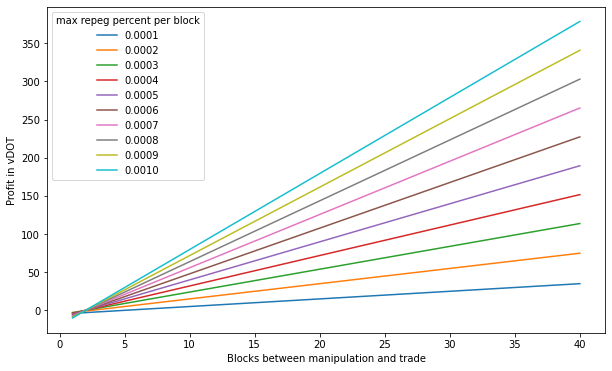

In [12]:
plt.figure(figsize=(10, 6))
for max_repeg in profits:
    plt.plot(block_cts, profits[max_repeg], label=f"{max_repeg:.4f}")
plt.xlabel("Blocks between manipulation and trade")
plt.ylabel("Profit in vDOT")
plt.legend(title="max repeg percent per block")
plt.show()